Загрузка библиотек

In [60]:
import os
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from datetime import timedelta

In [61]:
RANDOM_STATE = 128
path = 'flight_delays.csv'

In [62]:
data = pd.read_csv(path)


In [63]:
data.head()

,FlightID,Airline,FlightNumber,Origin,Destination,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,DelayMinutes,DelayReason,AircraftType,TailNumber,Distance
0,1,United,4558,ORD,MIA,2024-09-01 08:11,2024-09-01 08:30,2024-09-01 12:11,2024-09-01 12:19,8,Weather,Boeing 737,N71066,1031
1,2,Delta,8021,LAX,MIA,2024-09-01 10:25,2024-09-01 10:41,2024-09-01 13:25,2024-09-01 13:27,2,Air Traffic Control,Airbus A320,N22657,1006
2,3,Southwest,7520,DFW,SFO,2024-09-01 16:53,2024-09-01 17:05,2024-09-01 17:53,2024-09-01 18:07,14,Weather,Boeing 737,N95611,2980
3,4,Delta,2046,ORD,BOS,2024-09-01 14:44,2024-09-01 15:04,2024-09-01 18:44,2024-09-01 18:34,-10,NaN,Boeing 777,N90029,1408
4,5,Delta,6049,LAX,SEA,2024-09-01 01:51,2024-09-01 02:08,2024-09-01 05:51,2024-09-01 06:15,24,Air Traffic Control,Boeing 737,N27417,2298


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747627 entries, 0 to 1747626
Data columns (total 14 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   FlightID            int64 
 1   Airline             object
 2   FlightNumber        int64 
 3   Origin              object
 4   Destination         object
 5   ScheduledDeparture  object
 6   ActualDeparture     object
 7   ScheduledArrival    object
 8   ActualArrival       object
 9   DelayMinutes        int64 
 10  DelayReason         object
 11  AircraftType        object
 12  TailNumber          object
 13  Distance            int64 
dtypes: int64(4), object(10)
memory usage: 186.7+ MB


In [65]:
data.isnull().sum()

FlightID                   0
Airline                    0
FlightNumber               0
Origin                     0
Destination                0
ScheduledDeparture         0
ActualDeparture            0
ScheduledArrival           0
ActualArrival              0
DelayMinutes               0
DelayReason           468873
AircraftType               0
TailNumber                 0
Distance                   0
dtype: int64

Анализ данных

Исправим тип даных 

In [66]:
cols_to_time = ['ScheduledDeparture','ActualDeparture','ScheduledArrival','ActualArrival']



In [67]:
for i in cols_to_time:
    data[i] = pd.to_datetime(data[i])

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747627 entries, 0 to 1747626
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   FlightID            int64         
 1   Airline             object        
 2   FlightNumber        int64         
 3   Origin              object        
 4   Destination         object        
 5   ScheduledDeparture  datetime64[ns]
 6   ActualDeparture     datetime64[ns]
 7   ScheduledArrival    datetime64[ns]
 8   ActualArrival       datetime64[ns]
 9   DelayMinutes        int64         
 10  DelayReason         object        
 11  AircraftType        object        
 12  TailNumber          object        
 13  Distance            int64         
dtypes: datetime64[ns](4), int64(4), object(6)
memory usage: 186.7+ MB


Проверим наличия явных дубликатов 

In [69]:
data.drop(['FlightID', ],axis=1).duplicated().sum()

0

Создадим функцию для отоброжения категориальых данных

In [70]:
def cat_data_show(df, col, title , x_label):
    
    df[col].value_counts(ascending=True).plot.barh()
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()
    
    print(df[col].value_counts())

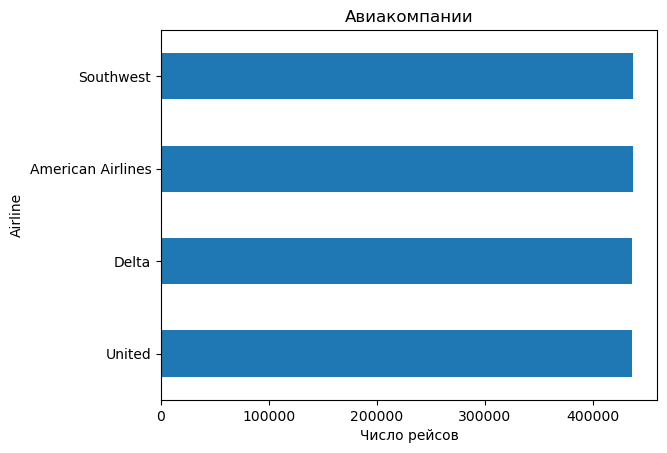

Airline
Southwest            437721
American Airlines    437124
Delta                436680
United               436102
Name: count, dtype: int64


In [71]:
cat_data_show(data,'Airline', 'Авиакомпании', 'Число рейсов')

Все авиакомпании совершили примерно одинаковое число вылетов 

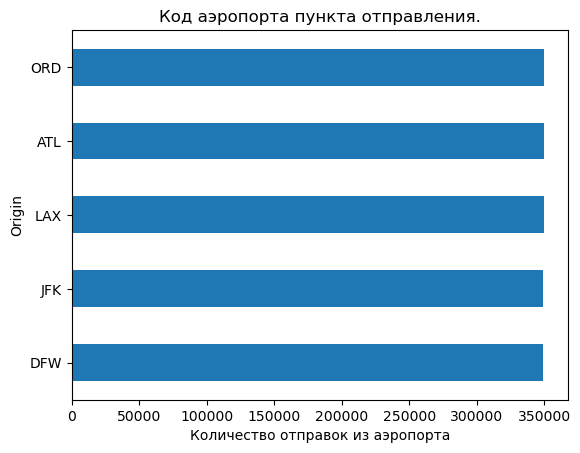

Origin
ORD    350059
ATL    349767
LAX    349667
JFK    349208
DFW    348926
Name: count, dtype: int64


In [72]:
cat_data_show(data,'Origin', 'Код аэропорта пункта отправления.', "Количество отправок из аэропорта")

Создадим сводную таблицу. По аэропортам и авиалиниям. Узнаем какая авиалиния больше всего из какого аэропорта совершает вылеты

In [73]:
data.pivot_table(index='Airline', columns='Origin', values='FlightID', aggfunc='count').sort_values('Airline', ascending=True)

Origin,ATL,DFW,JFK,LAX,ORD
Airline,,,,,
American Airlines,87797,86920,87289,87554,87564
Delta,87622,86757,87378,87247,87676
Southwest,87063,87910,87633,87566,87549
United,87285,87339,86908,87300,87270


Как мы можем наблюдать Лидером авиаперевозок из аэропорта ATL является Американские авиалинии 

Рассмотрим причины задержек и типы самолетов

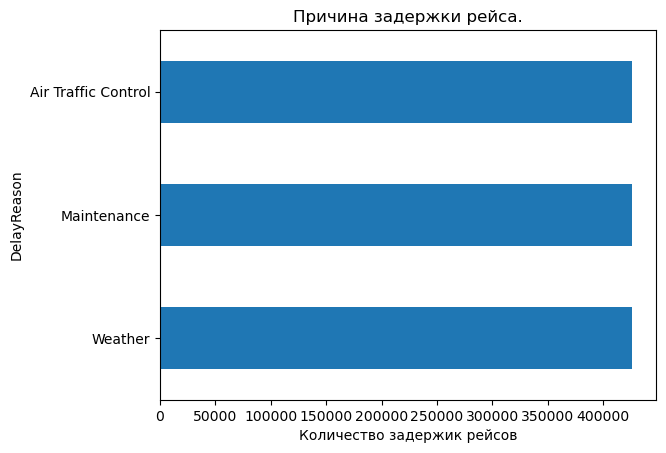

DelayReason
Air Traffic Control    426488
Maintenance            426168
Weather                426098
Name: count, dtype: int64


In [74]:
cat_data_show(data,'DelayReason', 'Причина задержки рейса.', "Количество задержик рейсов")

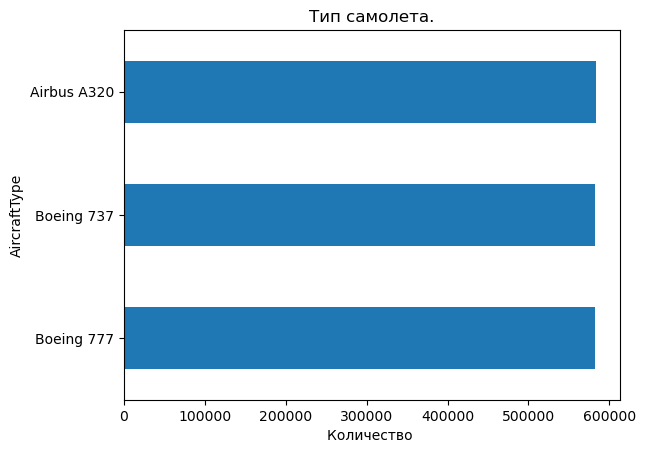

AircraftType
Airbus A320    583445
Boeing 737     582543
Boeing 777     581639
Name: count, dtype: int64


In [75]:
cat_data_show(data,'AircraftType', 'Тип самолета.', "Количество ")

Создадим сводную таблицу. Определим какие типы самoлетов по каким причинам больше всего задерживаются.

In [76]:
pivot = data.pivot_table(index=['AircraftType','DelayReason'], values='DelayMinutes', aggfunc=['mean', 'count'])
pivot.columns = ['Среднее время задержки', 'Количество задержек']
pivot

Среднее время задержки  Количество задержек
AircraftType DelayReason                                                     
Airbus A320  Air Traffic Control               15.488536               142401
             Maintenance                       15.524396               141988
             Weather                           15.476267               142040
Boeing 737   Air Traffic Control               15.512984               142291
             Maintenance                       15.490637               142154
             Weather                           15.487893               141941
Boeing 777   Air Traffic Control               15.500035               141796
             Maintenance                       15.491621               142026
             Weather                           15.513605               142117

Как мы можем увидеть для Airbus A320 главной причиной по продолжительности задержекой является Maintenance. Однако по количеству задержек 
на данный тип самолетов Air Traffic Control	

Для Boeing 737	главной причиной по продолжительности задержекой является Air Traffic Control. И по количеству задержек Air Traffic Control

Для Boeing 777	главной причиной по продолжительности задержекой является Weather.  И по количеству задержек Weather

В целом боинги кажутся более предсказуемыми чем Airbus

Бортовые номера самалетов. Каждый самолет имеет уникальный бортовой номер. Как мы можем видеть ниже все самолеты совершали более одного полета 

In [77]:
data['TailNumber'].value_counts()

TailNumber
N78834    40
N93094    39
N77709    39
N26912    38
N55344    38
          ..
N17934     5
N72320     5
N76754     4
N64760     4
N82963     4
Name: count, Length: 90000, dtype: int64

Давайте рассмотрим данные по самолетам и авиакомпаниям время ожидания в которых составило более 25

In [78]:
too_long_wait = data[data['DelayMinutes']>25]
too_long_wait

,FlightID,Airline,FlightNumber,Origin,Destination,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,DelayMinutes,DelayReason,AircraftType,TailNumber,Distance
11,12,American Airlines,5251,DFW,BOS,2024-09-01 19:18:00,2024-09-01 19:41:00,2024-09-01 21:18:00,2024-09-01 21:48:00,30,Weather,Airbus A320,N94983,131
14,15,Delta,2478,ORD,SFO,2024-09-01 13:54:00,2024-09-01 14:05:00,2024-09-01 18:54:00,2024-09-01 19:20:00,26,Weather,Boeing 777,N88239,498
18,19,American Airlines,390,JFK,BOS,2024-09-01 01:52:00,2024-09-01 02:03:00,2024-09-01 07:52:00,2024-09-01 08:18:00,26,Weather,Airbus A320,N65966,2268
21,22,American Airlines,9470,LAX,SEA,2024-09-01 13:03:00,2024-09-01 13:09:00,2024-09-01 18:03:00,2024-09-01 18:32:00,29,Maintenance,Airbus A320,N44604,1036
23,24,Delta,8277,JFK,JFK,2024-09-01 01:27:00,2024-09-01 01:40:00,2024-09-01 02:27:00,2024-09-01 02:53:00,26,Maintenance,Boeing 737,N40985,2198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747572,1747573,United,9652,ORD,SFO,2024-09-01 10:29:00,2024-09-01 10:29:00,2024-09-01 11:29:00,2024-09-01 11:56:00,27,Weather,Airbus A320,N44591,1731
1747589,1747590,United,7969,LAX,MIA,2024-09-01 22:32:00,2024-09-01 22:52:00,2024-09-02 03:32:00,2024-09-02 04:01:00,29,Weather,Airbus A320,N26382,137
1747596,1747597,Southwest,8559,LAX,SFO,2024-09-01 00:40:00,2024-09-01 01:05:00,2024-09-01 04:40:00,2024-09-01 05:06:00,26,Air Traffic Control,Airbus A320,N10557,1392
1747607,1747608,Southwest,6994,ORD,SFO,2024-09-01 18:27:00,2024-09-01 18:54:00,2024-09-01 20:27:00,2024-09-01 20:56:00,29,Weather,Airbus A320,N95442,598


In [79]:
pivot = too_long_wait.pivot_table(index = 'Airline', values='DelayMinutes', aggfunc=['sum', 'count'])
pivot.columns = ['Суммароное время задержок в мин', "Количество задержок более 25 мин"]
pivot

,Суммароное время задержок в мин,Количество задержок более 25 мин
Airline,,
American Airlines,1499330,53539
Delta,1475165,52685
Southwest,1502912,53669
United,1484278,53032


Как мы можем видеть рекортсменом по количеству и по длительности длительных задержок является Southwest.
А вот Delta менее всех имеет длительное число задержек.

In [80]:
plane_with_delay = too_long_wait.pivot_table(index='TailNumber', values='DelayMinutes', aggfunc='mean')
plane_with_delay.columns= ['Среднее время ожидания']
plane_with_delay

,Среднее время ожидания
TailNumber,
N10000,29.000000
N10001,29.500000
N10002,27.000000
N10003,28.000000
N10004,27.500000
...,...
N99994,29.333333
N99995,27.000000
N99996,28.000000


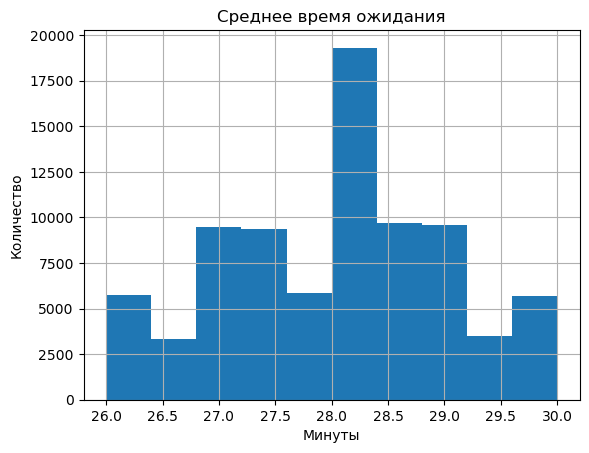

In [81]:
plane_with_delay.hist()
plt.xlabel('Mинуты')
plt.ylabel('Количество')
plt.show()

In [82]:
plane_with_delay.describe()

,Среднее время ожидания
count,81594.000000
mean,27.998375
std,1.019232
min,26.000000
25%,27.333333
50%,28.000000
75%,28.666667
max,30.000000


В принципе все самолеты "Длительных ожиданий" имеют среднее 28 минутное время ожидания.  Нельзя сказать что причиной являются проблемы с самолетами

Взглянем в какой месяц и год совершались полеты 

In [83]:
pd.DatetimeIndex(data['ActualDeparture']).year.value_counts()

ActualDeparture
2024    1747627
Name: count, dtype: int64

In [84]:
pd.DatetimeIndex(data['ActualDeparture']).month.value_counts()

ActualDeparture
9    1747627
Name: count, dtype: int64

In [85]:
pd.DatetimeIndex(data['ActualDeparture']).day.value_counts()

ActualDeparture
1    1729293
2      18334
Name: count, dtype: int64

Все вылеты и состоялись в 2024 году между 1-2 сентебря.  Данный сценарий кажется крайне маловероятным. Учитывая количество перелетов в 1.8 миллионов. Складывается впячетления что данные сгенерированы в ручную

Создадим новые призныки.

Время в пути в минутах 

Время опоздания вылета в минутах 

Время опоздания прилета в минутах 

In [86]:
data['time_on_road_min'] = (data['ActualArrival'] - data['ActualDeparture']).dt.total_seconds()/60

In [87]:
data['time_should_late_go_min'] =  (data['ActualDeparture'] - data['ScheduledDeparture']).dt.total_seconds()/60

In [88]:
data['speed'] = data['Distance'] / (data['time_on_road_min']/60)

In [89]:
data.head()

,FlightID,Airline,FlightNumber,Origin,Destination,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,DelayMinutes,DelayReason,AircraftType,TailNumber,Distance,time_on_road_min,time_should_late_go_min,speed
0,1,United,4558,ORD,MIA,2024-09-01 08:11:00,2024-09-01 08:30:00,2024-09-01 12:11:00,2024-09-01 12:19:00,8,Weather,Boeing 737,N71066,1031,229.0,19.0,270.131004
1,2,Delta,8021,LAX,MIA,2024-09-01 10:25:00,2024-09-01 10:41:00,2024-09-01 13:25:00,2024-09-01 13:27:00,2,Air Traffic Control,Airbus A320,N22657,1006,166.0,16.0,363.614458
2,3,Southwest,7520,DFW,SFO,2024-09-01 16:53:00,2024-09-01 17:05:00,2024-09-01 17:53:00,2024-09-01 18:07:00,14,Weather,Boeing 737,N95611,2980,62.0,12.0,2883.870968
3,4,Delta,2046,ORD,BOS,2024-09-01 14:44:00,2024-09-01 15:04:00,2024-09-01 18:44:00,2024-09-01 18:34:00,-10,NaN,Boeing 777,N90029,1408,210.0,20.0,402.285714
4,5,Delta,6049,LAX,SEA,2024-09-01 01:51:00,2024-09-01 02:08:00,2024-09-01 05:51:00,2024-09-01 06:15:00,24,Air Traffic Control,Boeing 737,N27417,2298,247.0,17.0,558.218623


Создадим функцию для отображения числовых данных 

In [90]:
def numeric_data_show(df,col, title, xlabel):
    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize = (8,5))
    ax1.hist(df[col])
    ax1.set_ylabel('Количество')
    ax1.set_xlabel(xlabel)
    
    
    ax2.boxplot(df[col])
    ax2.set_xlabel(xlabel)
    plt.title(title)
    plt.show()
    print(df[col].describe())

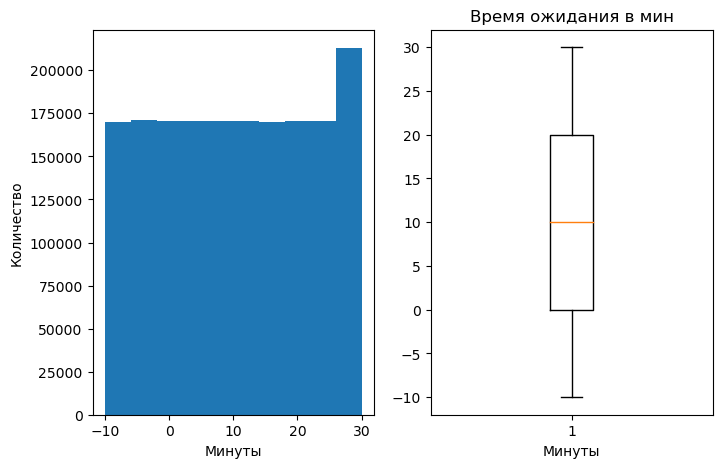

count    1.747627e+06
mean     9.999179e+00
std      1.183112e+01
min     -1.000000e+01
25%      0.000000e+00
50%      1.000000e+01
75%      2.000000e+01
max      3.000000e+01
Name: DelayMinutes, dtype: float64


In [91]:
numeric_data_show(data,'DelayMinutes', 'Время ожидания в мин','Минуты')

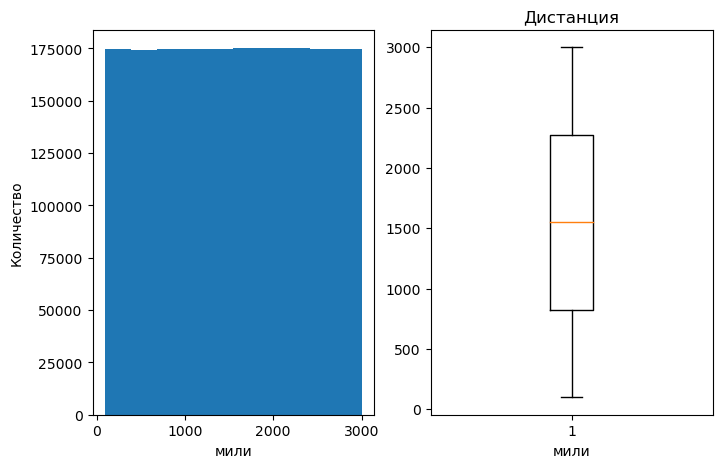

count    1.747627e+06
mean     1.549936e+03
std      8.368681e+02
min      1.000000e+02
25%      8.250000e+02
50%      1.551000e+03
75%      2.274000e+03
max      3.000000e+03
Name: Distance, dtype: float64


In [92]:
numeric_data_show(data,'Distance', 'Дистанция','мили')

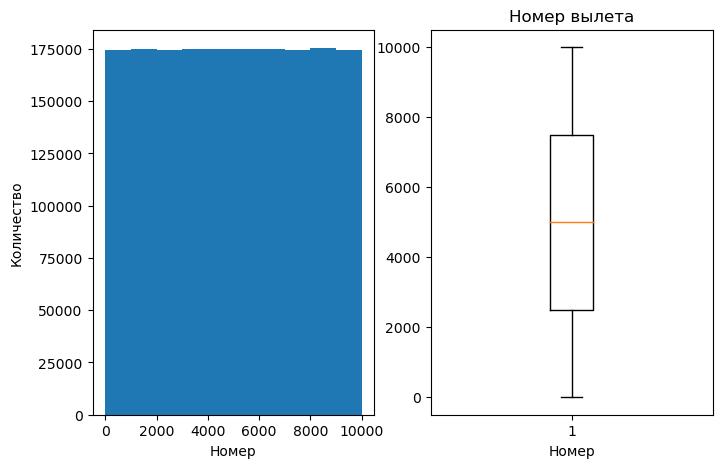

count    1.747627e+06
mean     5.001158e+03
std      2.885822e+03
min      1.000000e+00
25%      2.503000e+03
50%      5.002000e+03
75%      7.499000e+03
max      9.999000e+03
Name: FlightNumber, dtype: float64


In [93]:
numeric_data_show(data,'FlightNumber', 'Номер вылета','Номер')

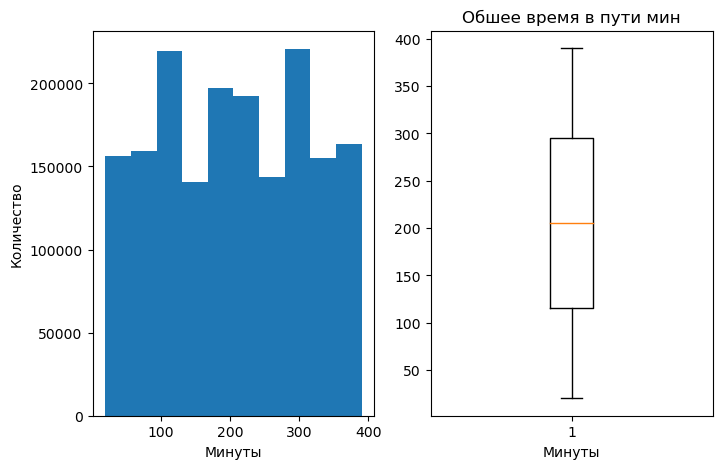

count    1.747627e+06
mean     2.050120e+02
std      1.035270e+02
min      2.000000e+01
25%      1.150000e+02
50%      2.050000e+02
75%      2.950000e+02
max      3.900000e+02
Name: time_on_road_min, dtype: float64


In [94]:
numeric_data_show(data,'time_on_road_min', 'Обшее время в пути мин','Минуты')

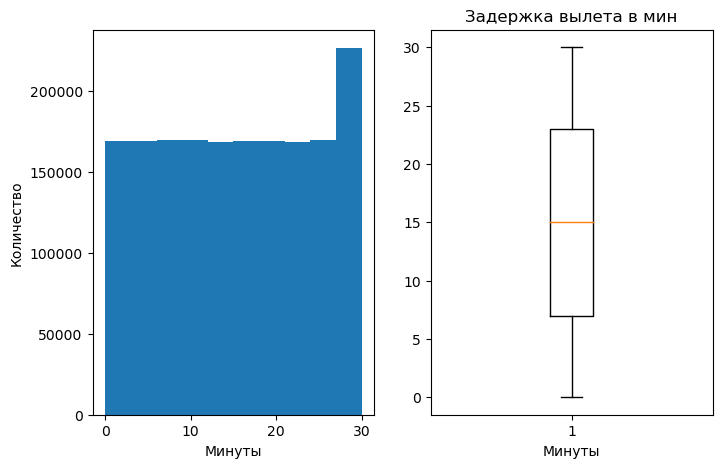

count    1.747627e+06
mean     1.499973e+01
std      8.949255e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.500000e+01
75%      2.300000e+01
max      3.000000e+01
Name: time_should_late_go_min, dtype: float64


In [95]:
numeric_data_show(data,'time_should_late_go_min', 'Задержка вылета в мин','Минуты')

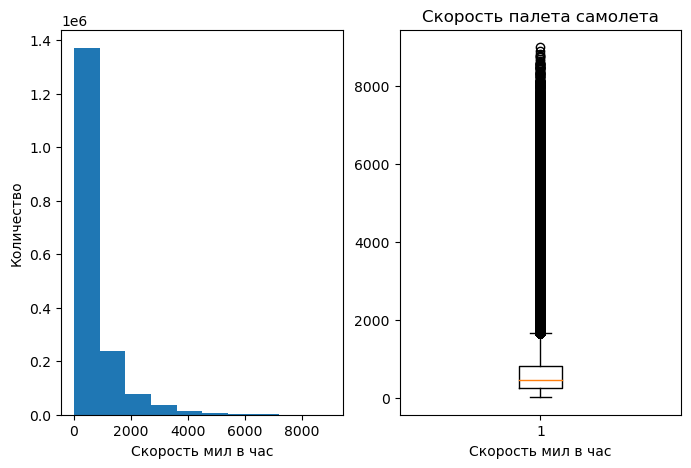

count    1.747627e+06
mean     6.956914e+02
std      7.761948e+02
min      1.546392e+01
25%      2.416514e+02
50%      4.533884e+02
75%      8.119355e+02
max      8.997000e+03
Name: speed, dtype: float64


In [96]:
numeric_data_show(data,'speed', 'Скорость палета самолета','Скорость мил в час')

Удалим выбрасы. 

In [97]:
indexs = data[data['speed']>1100].index
len(indexs)

293469

In [98]:
data.drop(indexs, inplace=True)

In [99]:
data.reset_index(drop=True)

,FlightID,Airline,FlightNumber,Origin,Destination,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,DelayMinutes,DelayReason,AircraftType,TailNumber,Distance,time_on_road_min,time_should_late_go_min,speed
0,1,United,4558,ORD,MIA,2024-09-01 08:11:00,2024-09-01 08:30:00,2024-09-01 12:11:00,2024-09-01 12:19:00,8,Weather,Boeing 737,N71066,1031,229.0,19.0,270.131004
1,2,Delta,8021,LAX,MIA,2024-09-01 10:25:00,2024-09-01 10:41:00,2024-09-01 13:25:00,2024-09-01 13:27:00,2,Air Traffic Control,Airbus A320,N22657,1006,166.0,16.0,363.614458
2,4,Delta,2046,ORD,BOS,2024-09-01 14:44:00,2024-09-01 15:04:00,2024-09-01 18:44:00,2024-09-01 18:34:00,-10,NaN,Boeing 777,N90029,1408,210.0,20.0,402.285714
3,5,Delta,6049,LAX,SEA,2024-09-01 01:51:00,2024-09-01 02:08:00,2024-09-01 05:51:00,2024-09-01 06:15:00,24,Air Traffic Control,Boeing 737,N27417,2298,247.0,17.0,558.218623
4,7,Southwest,4188,ORD,JFK,2024-09-01 05:47:00,2024-09-01 06:02:00,2024-09-01 10:47:00,2024-09-01 10:54:00,7,Weather,Boeing 777,N25382,1674,292.0,15.0,343.972603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454153,1747622,American Airlines,5071,DFW,SEA,2024-09-01 10:22:00,2024-09-01 10:38:00,2024-09-01 13:22:00,2024-09-01 13:27:00,5,Weather,Boeing 737,N22395,2887,169.0,16.0,1024.970414
1454154,1747623,United,4145,DFW,MIA,2024-09-01 12:46:00,2024-09-01 12:54:00,2024-09-01 17:46:00,2024-09-01 17:41:00,-5,NaN,Boeing 737,N19796,2396,287.0,8.0,500.905923
1454155,1747625,Delta,4878,JFK,SFO,2024-09-01 03:26:00,2024-09-01 03:47:00,2024-09-01 06:26:00,2024-09-01 06:20:00,-6,NaN,Boeing 777,N18964,361,153.0,21.0,141.568627
1454156,1747626,Delta,2940,JFK,SEA,2024-09-01 08:04:00,2024-09-01 08:07:00,2024-09-01 13:04:00,2024-09-01 13:20:00,16,Maintenance,Airbus A320,N94591,2793,313.0,3.0,535.399361


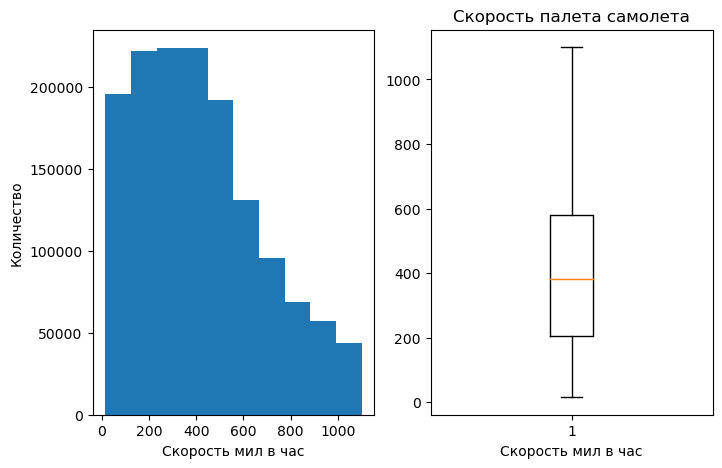

count    1.454158e+06
mean     4.174437e+02
std      2.618017e+02
min      1.546392e+01
25%      2.058904e+02
50%      3.822222e+02
75%      5.808571e+02
max      1.100000e+03
Name: speed, dtype: float64


In [100]:
numeric_data_show(data,'speed', 'Скорость палета самолета','Скорость мил в час')

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1454158 entries, 0 to 1747626
Data columns (total 17 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   FlightID                 1454158 non-null  int64         
 1   Airline                  1454158 non-null  object        
 2   FlightNumber             1454158 non-null  int64         
 3   Origin                   1454158 non-null  object        
 4   Destination              1454158 non-null  object        
 5   ScheduledDeparture       1454158 non-null  datetime64[ns]
 6   ActualDeparture          1454158 non-null  datetime64[ns]
 7   ScheduledArrival         1454158 non-null  datetime64[ns]
 8   ActualArrival            1454158 non-null  datetime64[ns]
 9   DelayMinutes             1454158 non-null  int64         
 10  DelayReason              1080969 non-null  object        
 11  AircraftType             1454158 non-null  object        
 12  TailN

Вывод по Анализу данных  

Все авиакомпании совершили примерно одинаковое число вылетов

Как мы можем наблюдать Лидером авиаперевозок из аэропорта ATL является Американские авиалинии

Как мы можем увидеть для Airbus A320 главной причиной по продолжительности задержекой является Maintenance. Однако по количеству задержек на данный тип самолетов Air Traffic Control

Для Boeing 737 главной причиной по продолжительности задержекой является Air Traffic Control. И по количеству задержек Air Traffic Control

Для Boeing 777 главной причиной по продолжительности задержекой является Weather. И по количеству задержек Weather

В целом боинги кажутся более предсказуемыми чем Airbus

Бортовые номера самалетов. Каждый самолет имеет уникальный бортовой номер. Как мы можем видеть ниже все самолеты совершали более одного полета

Как мы можем видеть рекортсменом по количеству и по длительности длительных задержок является Southwest. А вот Delta менее всех имеет длительное число задержек.

В принципе все самолеты "Длительных ожиданий" имеют среднее 28 минутное время ожидания. Нельзя сказать что причиной являются проблемы с самолетами

Все вылеты и состоялись в 2024 году между 1-2 сентебря. Данный сценарий кажется крайне маловероятным. Учитывая количество перелетов в 1.8 миллионов. Складывается впячетления что данные сгенерированы в ручную

Среднее время ожидания 9 мин. Есть рейсы которые прилетают раньше положенного срока 

Средняя дистанция перелетов 1500 миль

Среднее время полета состовляет 200 мин 

Скорость полета  

Среднее время задержки вылета состовляет 15 мин 




Примечание 
--

Данные скорей всего подтасованы. Или же в результате сбора данных произошла ошибка. 
--

Подготовка к обучению модели

In [102]:
data = data.drop(['FlightID', 'ScheduledDeparture','ActualDeparture','ScheduledArrival','ActualArrival'], axis=1)

Так как задачей является нахождения времени задержки прилета. То удалим данные ранных прибытий рейсов

In [103]:
index = data[data['DelayMinutes']<0].index
len(index)

338658

In [104]:
data.drop(index, inplace=True)

In [105]:
data.reset_index(drop=True)

,Airline,FlightNumber,Origin,Destination,DelayMinutes,DelayReason,AircraftType,TailNumber,Distance,time_on_road_min,time_should_late_go_min,speed
0,United,4558,ORD,MIA,8,Weather,Boeing 737,N71066,1031,229.0,19.0,270.131004
1,Delta,8021,LAX,MIA,2,Air Traffic Control,Airbus A320,N22657,1006,166.0,16.0,363.614458
2,Delta,6049,LAX,SEA,24,Air Traffic Control,Boeing 737,N27417,2298,247.0,17.0,558.218623
3,Southwest,4188,ORD,JFK,7,Weather,Boeing 777,N25382,1674,292.0,15.0,343.972603
4,Southwest,3179,DFW,MIA,24,Weather,Boeing 777,N65410,2931,238.0,26.0,738.907563
...,...,...,...,...,...,...,...,...,...,...,...,...
1115495,Southwest,4376,LAX,SEA,7,Maintenance,Airbus A320,N90451,1884,181.0,6.0,624.530387
1115496,Southwest,3902,DFW,SEA,15,Weather,Boeing 737,N30929,1253,365.0,10.0,205.972603
1115497,American Airlines,5071,DFW,SEA,5,Weather,Boeing 737,N22395,2887,169.0,16.0,1024.970414
1115498,Delta,2940,JFK,SEA,16,Maintenance,Airbus A320,N94591,2793,313.0,3.0,535.399361


Проверим данные на мультиколлинеарность

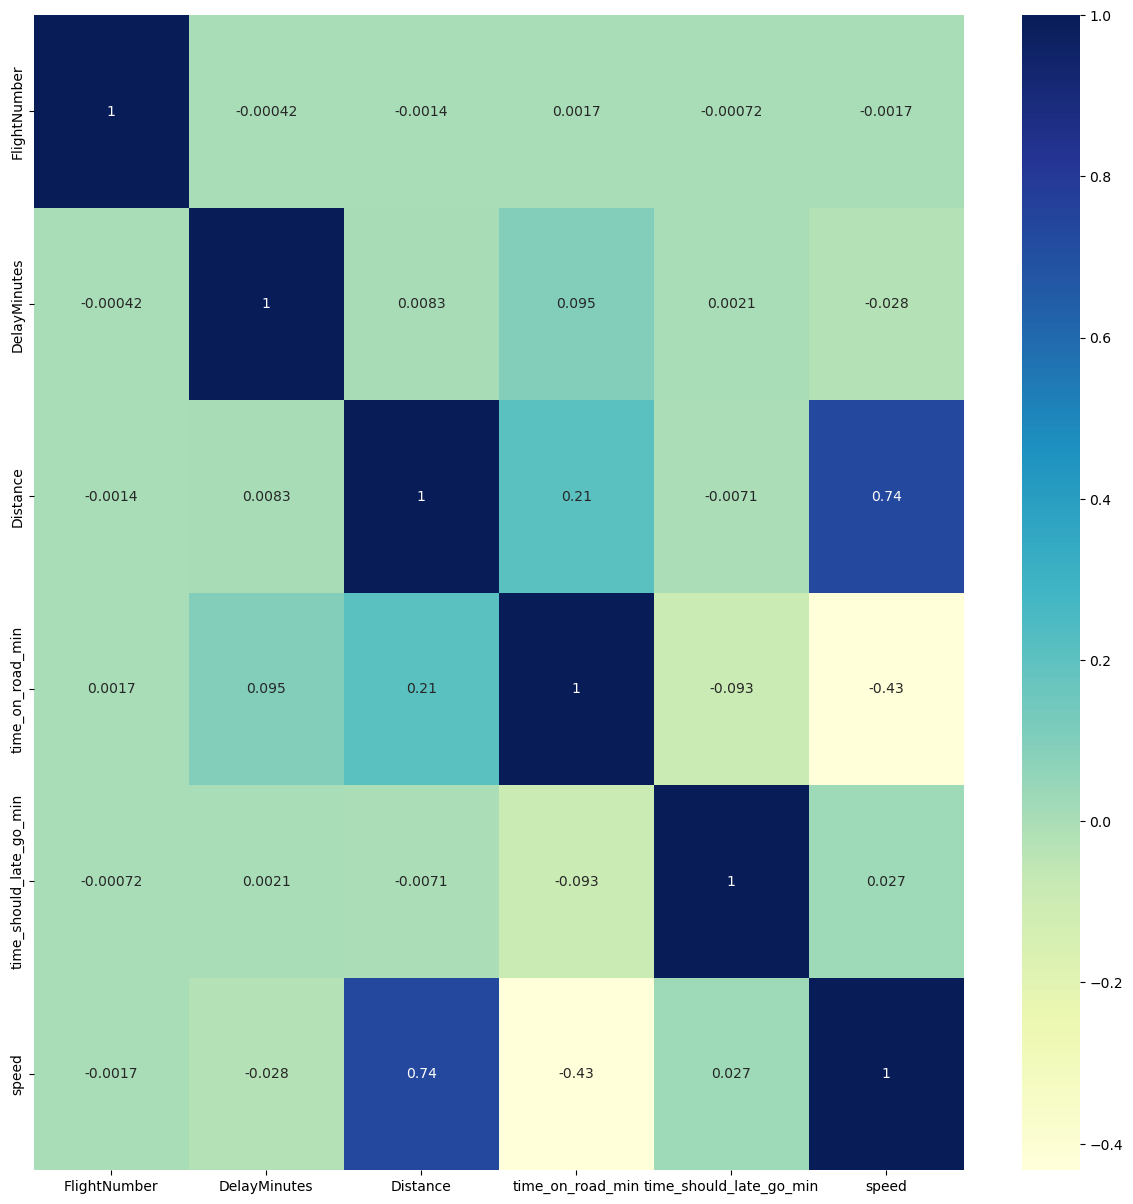

In [106]:
num_columns = data.select_dtypes(include='number')

plt.figure(figsize=(15,15))
sns.heatmap(num_columns.corr(method='spearman'), cmap="YlGnBu", annot=True) 
plt.show()


Мультиколлинеарность не выявлено

In [107]:
x = data.drop('DelayMinutes', axis=1)
y = data['DelayMinutes']

In [108]:
x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(892400, 11) (223100, 11) (892400,) (223100,)


In [109]:
ohe_columns = ['Airline', 'Origin', 'Destination', 'DelayReason', 'AircraftType']
ord_columns = ['TailNumber']
num_columns = ['FlightNumber', 'Distance', 'time_on_road_min','time_should_late_go_min', 'speed']

In [110]:
pipe_ohe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)) 
])

pipe_ord = Pipeline([
    ('ord', OrdinalEncoder( handle_unknown='use_encoded_value', unknown_value=-1))
])

pipe_scal = Pipeline([
    ('scal', StandardScaler() )
])

In [111]:
preprocesing_pipiline = ColumnTransformer(
    [
        ('one_hot_encoder', pipe_ohe, ohe_columns),
        ('ord_encoder', pipe_ord, ord_columns),
        ('standart_scaler', pipe_scal, num_columns)
        
    ], 
    remainder='passthrough'
) 

In [112]:
final_pipiline_lr =  Pipeline([('preprocessing', preprocesing_pipiline),
                       ('model', LinearRegression())])

In [113]:
final_pipiline_lr.fit(x_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Airline', 'Origin',
                                                   'Destination', 'DelayReason',
                                                   'AircraftType']),
                                                 ('ord_encoder',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['TailNumber']),
                                                 ('standart_scaler',
                                                  Pipeline(steps=[('scal',
                                                                   StandardScaler())]),
                                                  ['FlightNumber', 'Distance',
                                                   'time_on_road_min',
                                                   'time_should_late_go_min',
                                                   'speed'])])),
                ('model', LinearRegression())])

In [114]:
pred_lr = final_pipiline_lr.predict(x_test)

In [115]:
mean_absolute_error(y_test,pred_lr)

7.259849944433719

Вывод:
---

В DelayReason выявлены пропуски

Подготовка данных :

4 строки переведены в временой формат 

Созданы 3 новых призныка 



Анализ данных

Все авиакомпании совершили примерно одинаковое число вылетов

Как мы можем наблюдать Лидером авиаперевозок из аэропорта ATL является Американские авиалинии

Как мы можем увидеть для Airbus A320 главной причиной по продолжительности задержекой является Maintenance. Однако по количеству задержек на данный тип самолетов Air Traffic Control

Для Boeing 737 главной причиной по продолжительности задержекой является Air Traffic Control. И по количеству задержек Air Traffic Control

Для Boeing 777 главной причиной по продолжительности задержекой является Weather. И по количеству задержек Weather

В целом боинги кажутся более предсказуемыми чем Airbus

Бортовые номера самалетов. Каждый самолет имеет уникальный бортовой номер. Как мы можем видеть ниже все самолеты совершали более одного полета

Как мы можем видеть рекортсменом по количеству и по длительности длительных задержок является Southwest. А вот Delta менее всех имеет длительное число задержек.

В принципе все самолеты "Длительных ожиданий" имеют среднее 28 минутное время ожидания. Нельзя сказать что причиной являются проблемы с самолетами

Все вылеты и состоялись в 2024 году между 1-2 сентебря. Данный сценарий кажется крайне маловероятным. Учитывая количество перелетов в 1.8 миллионов. Складывается впячетления что данные сгенерированы в ручную

Среднее время ожидания 9 мин. Есть рейсы которые прилетают раньше положенного срока

Средняя дистанция перелетов 1500 миль

Среднее время полета состовляет 200 мин

Среднее время задержки вылета состовляет 15 мин

Примечание 
---
Данные скорей всего подтасованы. Или же в результате сбора данных произошла ошибка. 
---



Мультиколлинеарность не выявлено

Подготовка данных для обучения модели 

Данные разделены на 80% обучающей и 20% тестовой

Данные масштбированы и закадированы 

Обучена модель линейной регресии. 

В результате обучения получена МАЕ равное 7


